# Partie II : Étude de la dérive

* Objectif : Évaluer la performance du modèle existant sur des données récentes et identifier les causes d'une éventuelle dégradation.

## Importation des Bibliothèques :


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder 
from sklearn.linear_model import LinearRegression
from typing import Dict, List, Any, Tuple
from scipy.spatial.distance import jensenshannon
from sklearn.ensemble import RandomForestRegressor
from common_function import(
          load_config ,
          load_data,
          load_model,
          detect_missing_values ,
          plot_box_plot,
          plot_feature_distribution,
          cap_outliers,
          log_transform,
          preprocess_modeling,
          analyze_data_drift,
          evaluation_metrics,
          evaluate_on_validation_set, 
          calculate_jsd_categorical,
          preprocess_columns,
          div_jen_shanon,
          comparer_matrices_correlation     
)

## 1.Chargement de la Configuration et des Données

In [7]:
config = load_config("config\config.yaml") #
data_drift=load_data(config['data']['drift_path'])
data_train=load_data(config['data']['train_path'])
data=data_drift
Numerical_colomuns=config['features']['numerical']
Categorical_columns=config['features']['categorical']
Numerical_colomuns_log=config['features']['numerical_log']


In [8]:
print(data.head())
print(data.info())

        PolicyId  AgeConducteur SexeConducteur StatutMatrimonial  BonusMalus  \
0  90144365.100b           33.0              M               NaN        55.0   
1  90194873.100a           40.0              M               NaN       129.0   
2  90134157.100a           28.0              M               NaN        55.0   
3  90109178.102a           40.0              M        Cohabiting       140.0   
4  90170847.100a           23.0              M               NaN       106.0   

  FrequencePaiement    CodeProfession  AgeVehicule ClasseVehicule  \
0       Half-yearly               NaN         11.0        Cheaper   
1            Annual               NaN          7.0          Cheap   
2       Half-yearly               NaN         15.0        Cheaper   
3            Annual  Private employee         10.0       Cheapest   
4            Annual               NaN         34.0          Cheap   

  PuissanceVehicule CarburantVehicule           UsageVehicule  \
0               P12            Diesel  

## 2. Fonctions auxiliaires

In [9]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame: 
    """
    Pré-traite les données en remplissant les valeurs manquantes pour certaines colonnes spécifiques.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données à pré-traiter.

    Returns:
        pd.DataFrame: Le DataFrame avec les valeurs manquantes remplies pour les colonnes 'StatutMatrimonial' et 'CodeProfession'.

    Étapes de pré-traitement :
        - Remplit les valeurs manquantes dans la colonne 'StatutMatrimonial' avec la modalité la plus fréquente.
        - Remplit les valeurs manquantes dans la colonne 'CodeProfession' avec "Non spécifié".
    """
    
    df['StatutMatrimonial'].fillna("Non spécifié", inplace=True)
    df['CodeProfession'].fillna("Non spécifié", inplace=True)
    return df

def add_interaction_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ajoute une caractéristique d'interaction entre l'âge du conducteur et l'âge du véhicule.
    """
    df['Driver_Vehicle_Age_Interaction'] = df['AgeConducteur_log'] * df['AgeVehicule_log']
    return df

def bin_age_conducteur(df: pd.DataFrame) -> pd.DataFrame:
    """
    Effectue un binning de 'AgeConducteur_log' en trois catégories : 'Young', 'Mature' et 'Senior'.
    """
    df['AgeConducteur_Binned'] = pd.cut(
        df['AgeConducteur_log'],
        bins=[-np.inf, np.log1p(25), np.log1p(50), np.inf],
        labels=['Young', 'Mature', 'Senior']
    )
    return df

def create_bonus_age_difference(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crée une nouvelle caractéristique en soustrayant l'âge du conducteur du BonusMalus.
    """
    df['Bonus_Age_Difference'] = df['BonusMalus_log'] - df['AgeConducteur_log']
    return df

def encode_binned_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encode la colonne 'AgeConducteur_Binned' en variables fictives (one-hot encoding).
    """
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(df[['AgeConducteur_Binned']])
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['AgeConducteur_Binned']))
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(columns=['AgeConducteur_Binned'], inplace=True)
    return df

def add_polynomial_features(df: pd.DataFrame, columns: list, degree: int = 2) -> pd.DataFrame:
    """
    Génère des caractéristiques polynomiales pour les colonnes spécifiées.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df[columns])
    poly_feature_names = poly.get_feature_names_out(columns)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
    df = pd.concat([df, poly_df], axis=1)
    return df
def tracer_distributions_categoriques(train_data :pd.DataFrame, new_data:pd.DataFrame, colonnes_categoriques:list)->None:
    """
    Visualise les distributions des colonnes catégoriques entre deux ensembles de données en utilisant des sous-graphiques.

    Paramètres :
    - train_data : DataFrame pour l'ensemble d'entraînement.
    - new_data : DataFrame pour l'ensemble de nouvelles données.
    - colonnes_categoriques : Liste des colonnes catégoriques à comparer.
    """
    # Calculer le nombre de lignes et de colonnes pour les sous-graphiques
    nb_colonnes = len(colonnes_categoriques)
    cols = 2  # Nombre de colonnes dans la grille de sous-graphiques
    rows = (nb_colonnes + cols - 1) // cols  # Calcul du nombre de lignes nécessaires
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Aplatir les axes pour les parcourir facilement
    
    for i, colonne in enumerate(colonnes_categoriques):
        # Fréquences des valeurs dans chaque ensemble
        frequence_train = train_data[colonne].value_counts(normalize=True).sort_index()
        frequence_new = new_data[colonne].value_counts(normalize=True).sort_index()
        
        # Combiner les deux distributions pour la comparaison
        comparaison_df = pd.DataFrame({
            "Entraînement": frequence_train,
            "Nouveau": frequence_new
        }).fillna(0)
        
        # Tracer le graphique en barres
        comparaison_df.plot(kind="bar", width=0.8, alpha=0.8, ax=axes[i])
        axes[i].set_title(f"Comparaison des distributions - {colonne}")
        axes[i].set_ylabel("Fréquence relative")
        axes[i].set_xlabel("Catégories")
        axes[i].legend(title="Ensemble de données")
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)
        axes[i].tick_params(axis="x", rotation=45)
    
    # Désactiver les axes inutilisés
    for j in range(len(colonnes_categoriques), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


## 3.Prétraitement des données

In [10]:
pre_data=preprocess_data(data).copy()
pre_train=preprocess_data(data_train).copy()

## 4. Nettoyage des donnés

In [11]:
X_data=pre_data
columns_do_capping = config['features']['capping']
for col in columns_do_capping:
    X_data = cap_outliers(X_data, col) #Limite les valeurs extrêmes pour stabiliser les distributions.

X_data=log_transform(X_data,Numerical_colomuns) #Limite les valeurs extrêmes pour stabiliser les distributions.
X_data.drop(columns=Numerical_colomuns, inplace=True) #Garde uniquement les versions transformées des colonnes.
print(X_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PolicyId              22481 non-null  object 
 1   SexeConducteur        22481 non-null  object 
 2   StatutMatrimonial     22481 non-null  object 
 3   FrequencePaiement     22481 non-null  object 
 4   CodeProfession        22481 non-null  object 
 5   ClasseVehicule        22481 non-null  object 
 6   PuissanceVehicule     22481 non-null  object 
 7   CarburantVehicule     22481 non-null  object 
 8   UsageVehicule         22481 non-null  object 
 9   Garage                22481 non-null  object 
 10  Region                22481 non-null  object 
 11  AgeConducteur_log     22481 non-null  float64
 12  BonusMalus_log        22481 non-null  float64
 13  AgeVehicule_log       22481 non-null  float64
 14  PrimeCommerciale_log  22481 non-null  float64
dtypes: float64(4), obje

## 5. Feature Engineering

In [12]:
X_data = add_interaction_feature(X_data)
X_data = bin_age_conducteur(X_data)
X_data = create_bonus_age_difference(X_data)
X_data = encode_binned_age(X_data)
#train_data = add_polynomial_features(train_data, ['AgeConducteur_log', 'BonusMalus_log'])

In [13]:
print("Feature-engineered Data:")
print(X_data.info())

Feature-engineered Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PolicyId                        22481 non-null  object 
 1   SexeConducteur                  22481 non-null  object 
 2   StatutMatrimonial               22481 non-null  object 
 3   FrequencePaiement               22481 non-null  object 
 4   CodeProfession                  22481 non-null  object 
 5   ClasseVehicule                  22481 non-null  object 
 6   PuissanceVehicule               22481 non-null  object 
 7   CarburantVehicule               22481 non-null  object 
 8   UsageVehicule                   22481 non-null  object 
 9   Garage                          22481 non-null  object 
 10  Region                          22481 non-null  object 
 11  AgeConducteur_log               22481 non-null  float64
 12  BonusMa

## 5.Analyse des dérives des données

In [14]:
Model=load_model(config['data']['model_path'])

In [15]:
X, y = preprocess_modeling(X_data, target_column='PrimeCommerciale_log', drop_columns=['PolicyId'])

In [16]:
expected_columns = list(Model.feature_names_in_)
X=preprocess_columns(X,expected_columns)

Extra columns in X: {'ClasseVehicule_Luxury cars', 'ClasseVehicule_Cheap'}
Missing columns in X: {'ClasseVehicule_Medium', 'ClasseVehicule_More expensive', 'ClasseVehicule_Most expensive', 'FrequencePaiement_Quarterly', 'ClasseVehicule_Medium high', 'ClasseVehicule_Medium low'}


In [17]:
assert list(X.columns) == list(expected_columns), "Les colonnes ne correspondent toujours pas !"

In [18]:
train_data_cleand=load_data(config['data']['train_cleaned_path'])
X_train,y_train=preprocess_modeling(train_data_cleand, target_column='PrimeCommerciale_log', drop_columns=['PolicyId'])

In [19]:
expected_columns = list(Model.feature_names_in_)
X_train = X_train[expected_columns]
y_pred_train = Model.predict(X_train)

In [20]:
print("Evaluation sur les donnés Entrainment")
print(evaluate_on_validation_set(Model,y_train,y_pred_train))

Evaluation sur les donnés Entrainment
{'Validation MSE': 0.051395177817689076, 'Validation R2': 0.770211730775267, 'Validation MAE': 0.17810084144223212, 'Validation RMSE': 0.2267050458584658}


In [21]:
y_pred_shift=Model.predict(X)
print("Evaluation sur les donnés drift")
print(evaluate_on_validation_set(Model,y,y_pred_shift))

Evaluation sur les donnés drift
{'Validation MSE': 0.3179964212502476, 'Validation R2': -0.9627771971778769, 'Validation MAE': 0.47531716408814456, 'Validation RMSE': 0.5639117140565956}


Les performances du modèle se sont fortement dégradées sur les données d’entraînement après le drift, comme en témoignent les métriques

le drift a un impact majeur sur les performances du modèle.

Un data drift dans les distributions des caractéristiques.
la relation entre les caractéristiques et la cible a changé.(Un concept drift )



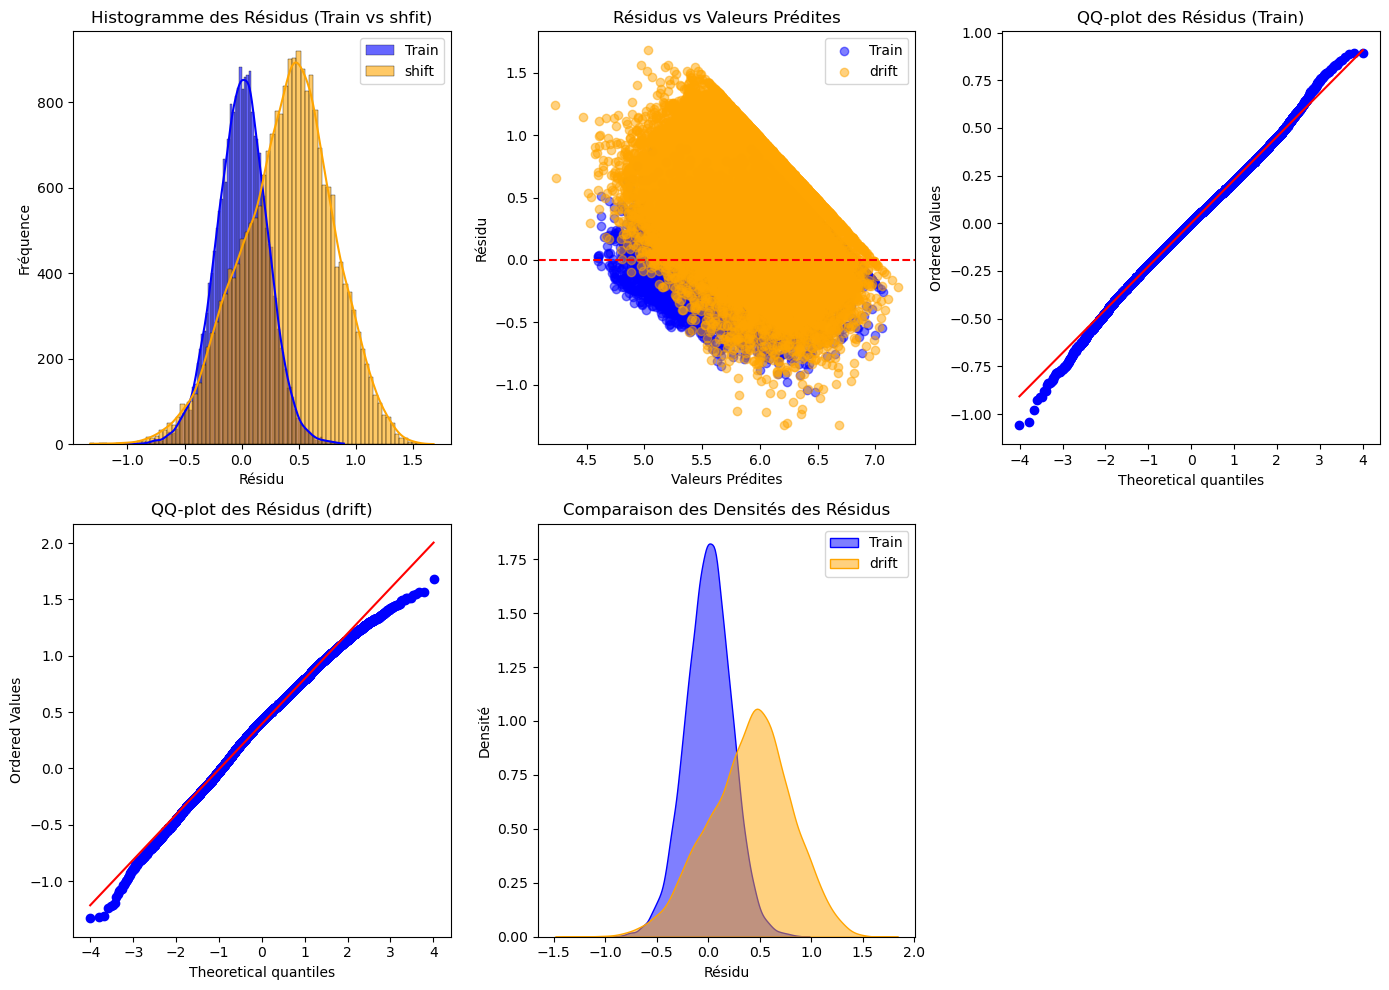

In [103]:
residuals_train = y_train - y_pred_train  # Résidus pour l'entraînement
residuals_shift = y - y_pred_shift   # Résidus pour le test

# Créer une figure
plt.figure(figsize=(14, 10))

# 1. Histogramme des résidus
plt.subplot(2, 3, 1)
sns.histplot(residuals_train, kde=True, color="blue", label="Train", alpha=0.6)
sns.histplot(residuals_shift, kde=True, color="orange", label="shift", alpha=0.6)
plt.title("Histogramme des Résidus (Train vs shfit)")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")
plt.legend()

# 2. Graphique des résidus vs valeurs prédites
plt.subplot(2, 3, 2)
plt.scatter(y_pred_train, residuals_train, alpha=0.5, color="blue", label="Train")
plt.scatter(y_pred_shift, residuals_shift, alpha=0.5, color="orange", label="drift")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Résidus vs Valeurs Prédites")
plt.xlabel("Valeurs Prédites")
plt.ylabel("Résidu")
plt.legend()

# 3. QQ-plot pour la normalité des résidus (Train)
plt.subplot(2, 3, 3)
stats.probplot(residuals_train, dist="norm", plot=plt)
plt.title("QQ-plot des Résidus (Train)")

# 4. QQ-plot pour la normalité des résidus ()
plt.subplot(2, 3, 4)
stats.probplot(residuals_shift, dist="norm", plot=plt)
plt.title("QQ-plot des Résidus (drift)")

# 5. Distribution comparative avec KDE
plt.subplot(2, 3, 5)
sns.kdeplot(residuals_train, color="blue", label="Train", fill=True, alpha=0.5)
sns.kdeplot(residuals_shift, color="orange", label="drift", fill=True, alpha=0.5)
plt.title("Comparaison des Densités des Résidus")
plt.xlabel("Résidu")
plt.ylabel("Densité")
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()


# Analyse des Résidus et Interprétation

## 1. Histogramme des Résidus (Train vs Drift)
- **Train (bleu)** : Résidus centrés autour de 0, distribution étroite.  
- **Drift (orange)** : Résidus déplacés vers des valeurs positives, distribution plus large.  
- **Conclusion** : Les prédictions sur le drift sont biaisées et sous-estiment systématiquement les valeurs réelles.

---

## 2. Résidus vs Valeurs Prédites
- **Train (bleu)** : Résidus uniformément répartis autour de 0.  
- **Drift (orange)** : Résidus croissants avec les prédictions, signalant une erreur systématique.  
- **Conclusion** : Le modèle ne généralise pas bien sur les données drift.

---

## 3. QQ-Plot des Résidus
- **Train** : Résidus alignés avec la diagonale, suggérant une distribution normale.  
- **Drift** : Déviation significative avec des valeurs extrêmes.  
- **Conclusion** : Les données drift introduisent un comportement non normal, révélant une mauvaise adaptation.

---

## 4. Comparaison des Densités des Résidus
- **Drift** : Résidus déplacés vers des valeurs positives avec une variance plus élevée.  
- **Conclusion** : Une dérive globale dans les données provoque un biais systématique dans les prédictions.

---

## Résumé
- Le modèle est sensible aux données drift, montrant des résidus biaisés et non uniformes.  
- **Impact** : Dégradation des performances et perte de généralisation.  
- **Action Recommandée** : Réentraîner le modèle sur des données récentes pour restaurer la robustesse.


# Analyse de la Dégradation des Performances et des Dérives .

## 1.data drift

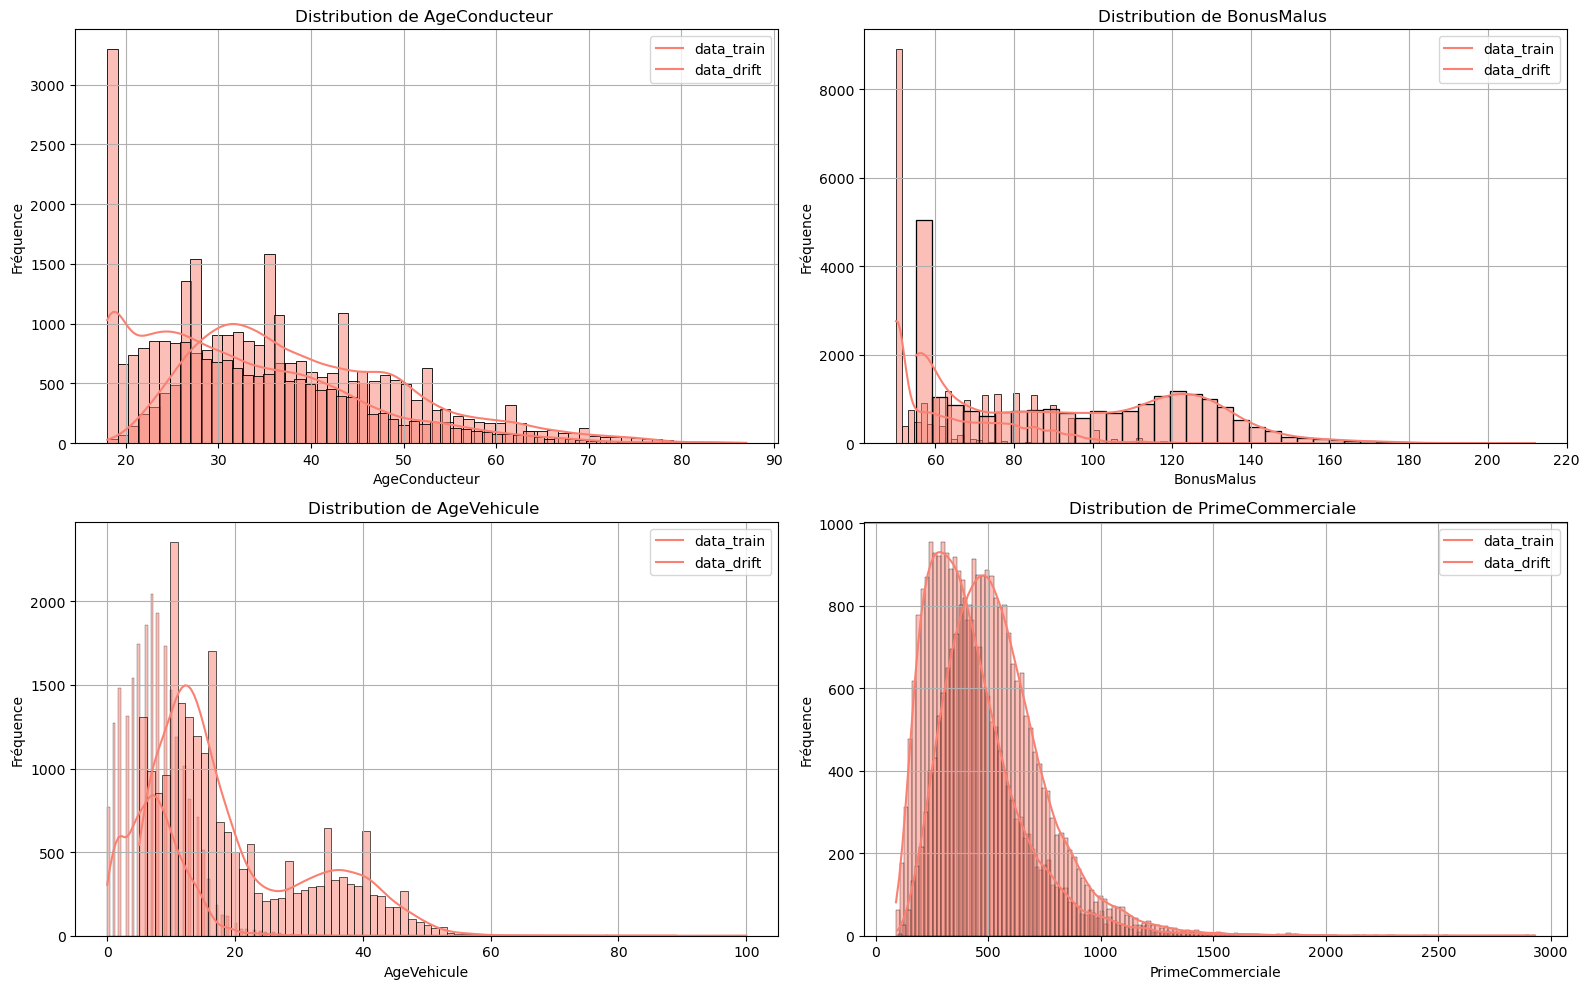

In [104]:
plt.figure(figsize=(16, 10))  # Setting up a large figure to hold all subplots

for i, col in enumerate(Numerical_colomuns, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    plot_feature_distribution(data_train, col)  # Plot for data_train
    plot_feature_distribution(data_drift, col)  # Plot for data_drift
    
    # Add a legend to indicate which dataset each color represents
    plt.legend(['data_train', 'data_drift'])

plt.tight_layout()  # Adjust layout for better spacing between plots
plt.show()

    

**AgeConducteur** 

* Augmentation des jeunes conducteurs (20-30 ans) dans les donnés drift.-> Changement modéré, influence sur les prédictions

**BonusMalus** 

* Forte augmentation des faibles valeurs dans data_drift.-> Dérive significative, risque élevé de mauvaise prédiction ((si le modèle est sensible à cette variable.))

**AgeVehicule**

* Augmentation des véhicules récents (0-20 ans), réduction des véhicules anciens. -> Dérive importante, reflète un changement notable dans les données.

**PrimeCommerciale** :

* Légères variations dans les plages, avec un glissement vers des valeurs plus élevéesChangement modéré, mais influence potentielle sur la prédiction des primes.



* Dérive notable observée sur BonusMalus et AgeVehicule.
* Ces changements expliquent une dégradation probable de la performance du modèle.
* ces changements affectent directement les prédictions du modèle car il a été entraîné sur des distributions différentes.

In [105]:
for col in Numerical_colomuns:
          analyze_data_drift(data_train,data_drift,col)

KS Test pour 'AgeConducteur': Statistique = 0.2944708865264001, p-value = 0.0
KS Test pour 'BonusMalus': Statistique = 0.4534940616520617, p-value = 0.0
KS Test pour 'AgeVehicule': Statistique = 0.5304034518037454, p-value = 0.0
KS Test pour 'PrimeCommerciale': Statistique = 0.27747875984164405, p-value = 0.0


# Analyse des KS Tests

## 1. Résultats Clés

### Statistique KS
- **Mesure** : Distance maximale entre distributions cumulées.  
- **Interprétation** : Plus elle est élevée, plus les distributions diffèrent.

### p-value
- **Résultat** : **0.0** pour toutes les variables, indiquant des différences **statistiquement significatives**.

---

## 2. Analyse par Variable

- **`AgeConducteur`** : KS = **0.294** (Différence modérée).  
  - Impact potentiel sur les performances.  

- **`BonusMalus`** : KS = **0.453** (Différence élevée).  
  - Dérive significative affectant les prédictions.  

- **`AgeVehicule`** : KS = **0.530** (Différence critique).  
  - Le modèle rencontre des cas non appris.  

- **`PrimeCommerciale`** : KS = **0.277** (Différence modérée).  
  - Liée directement à la cible, influence notable.  

---

## 3. Implications

- Les dérives majeures dans **`AgeVehicule`** et **`BonusMalus`** expliquent la **dégradation des performances**.  
- Le modèle est mal adapté aux distributions actuelles des données.

---

## 4. Recommandations

### A. Réentraîner le Modèle
- Collecter des données récentes et les intégrer dans l'entraînement.  

### B. Surveillance Continue
- Automatiser les KS Tests pour une détection proactive des dérives.  

### C. Analyse Complémentaire
- Identifier les causes des dérives :  
  - Augmentation des véhicules récents (**`AgeVehicule`**).  
  - Changements dans les politiques d'assurance (**`BonusMalus`**).  

---

## Conclusion

Les KS Tests révèlent des **dérives significatives** dans plusieurs variables clés. Un **réentraînement** et une **surveillance continue** sont essentiels pour restaurer les performances du modèle.


In [106]:
for col in Numerical_colomuns:
    jsd=calculate_jsd_categorical(data_train, data_drift, col)
    print(f"Jensen-Shannon Divergence for `{col}`: {jsd}")

Jensen-Shannon Divergence for `AgeConducteur`: 0.29978733143089725
Jensen-Shannon Divergence for `BonusMalus`: 0.7348987092606543
Jensen-Shannon Divergence for `AgeVehicule`: 0.4997547777199537
Jensen-Shannon Divergence for `PrimeCommerciale`: 0.8325546111576977


# Analyse de la Divergence de Jensen-Shannon (JS)

La divergence JS évalue la similarité entre deux distributions. Elle varie de 0 (identiques) à 1 (complètement différentes). Voici les points clés concernant la dérive des données et son impact sur les performances.

---

## 1. Dérives Identifiées

### Variables avec Dérive Majeure
- **`BonusMalus`** : JS = **0.7349**  
  → Changement dans les profils de risque.  
- **`PrimeCommerciale`** : JS = **0.8326**  
  → Nouvelle segmentation des primes.  

### Variables avec Dérive Modérée
- **`AgeVehicule`** : JS = **0.4998**  
  → Modification des âges moyens des véhicules.  
- **`AgeConducteur`** : JS = **0.2998**  
  → Changements démographiques des conducteurs.  

---

## 2. Impact sur les Performances

### Causes Principales
- **`BonusMalus`** : Changements significatifs dans la structure des données.  
- **`PrimeCommerciale`** : Évolution des tendances économiques.

### Effets Observés
- **Erreurs accrues** sur les prédictions des primes commerciales.  
- Moindre performance pour :
  - Les nouveaux profils de conducteurs.
  - Les véhicules de segments non appris.

---

## 3. Recommandations

### Variables Clés à Surveiller
- **`BonusMalus`** : Ajuster le modèle aux nouvelles règles de risque.  
- **`PrimeCommerciale`** : Réintégrer les nouvelles tendances économiques.  

### Actions à Entreprendre
- Réentraîner le modèle avec des données mises à jour.  
- Automatiser la détection des dérives pour des corrections proactives.

---

## Conclusion

Les divergences JS importantes pour **`BonusMalus`** et **`PrimeCommerciale`** confirment une dérive majeure. Pour maintenir la précision du modèle, un **réentraînement immédiat** est nécessaire.


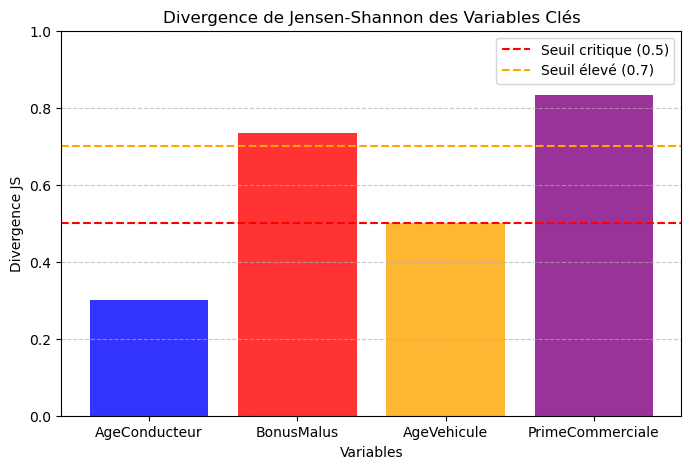

In [ ]:
# Données pour le graphique
variables = ["AgeConducteur", "BonusMalus", "AgeVehicule", "PrimeCommerciale"]
divergences = [0.2998, 0.7349, 0.4998, 0.8326]

# Création du barplot
plt.figure(figsize=(8, 5))
plt.bar(variables, divergences, color=['blue', 'red', 'orange', 'purple'], alpha=0.8)
plt.axhline(y=0.5, color='r', linestyle='--', label="Seuil critique (0.5)")
plt.axhline(y=0.7, color='orange', linestyle='--', label="Seuil élevé (0.7)")
plt.title("Divergence de Jensen-Shannon des Variables Clés")
plt.ylabel("Divergence JS")
plt.xlabel("Variables")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


* Les dérives significatives de BonusMalus et PrimeCommerciale indiquent un changement structurel dans les données récentes (changement dans les profils de risque et dans la segmentation des primes).
* La dégradation des performances est fortement liée à ces variables.
* Un réentraînement du modèle avec des données récentes, incluant ces nouvelles distributions, est nécessaire pour restaurer la précision

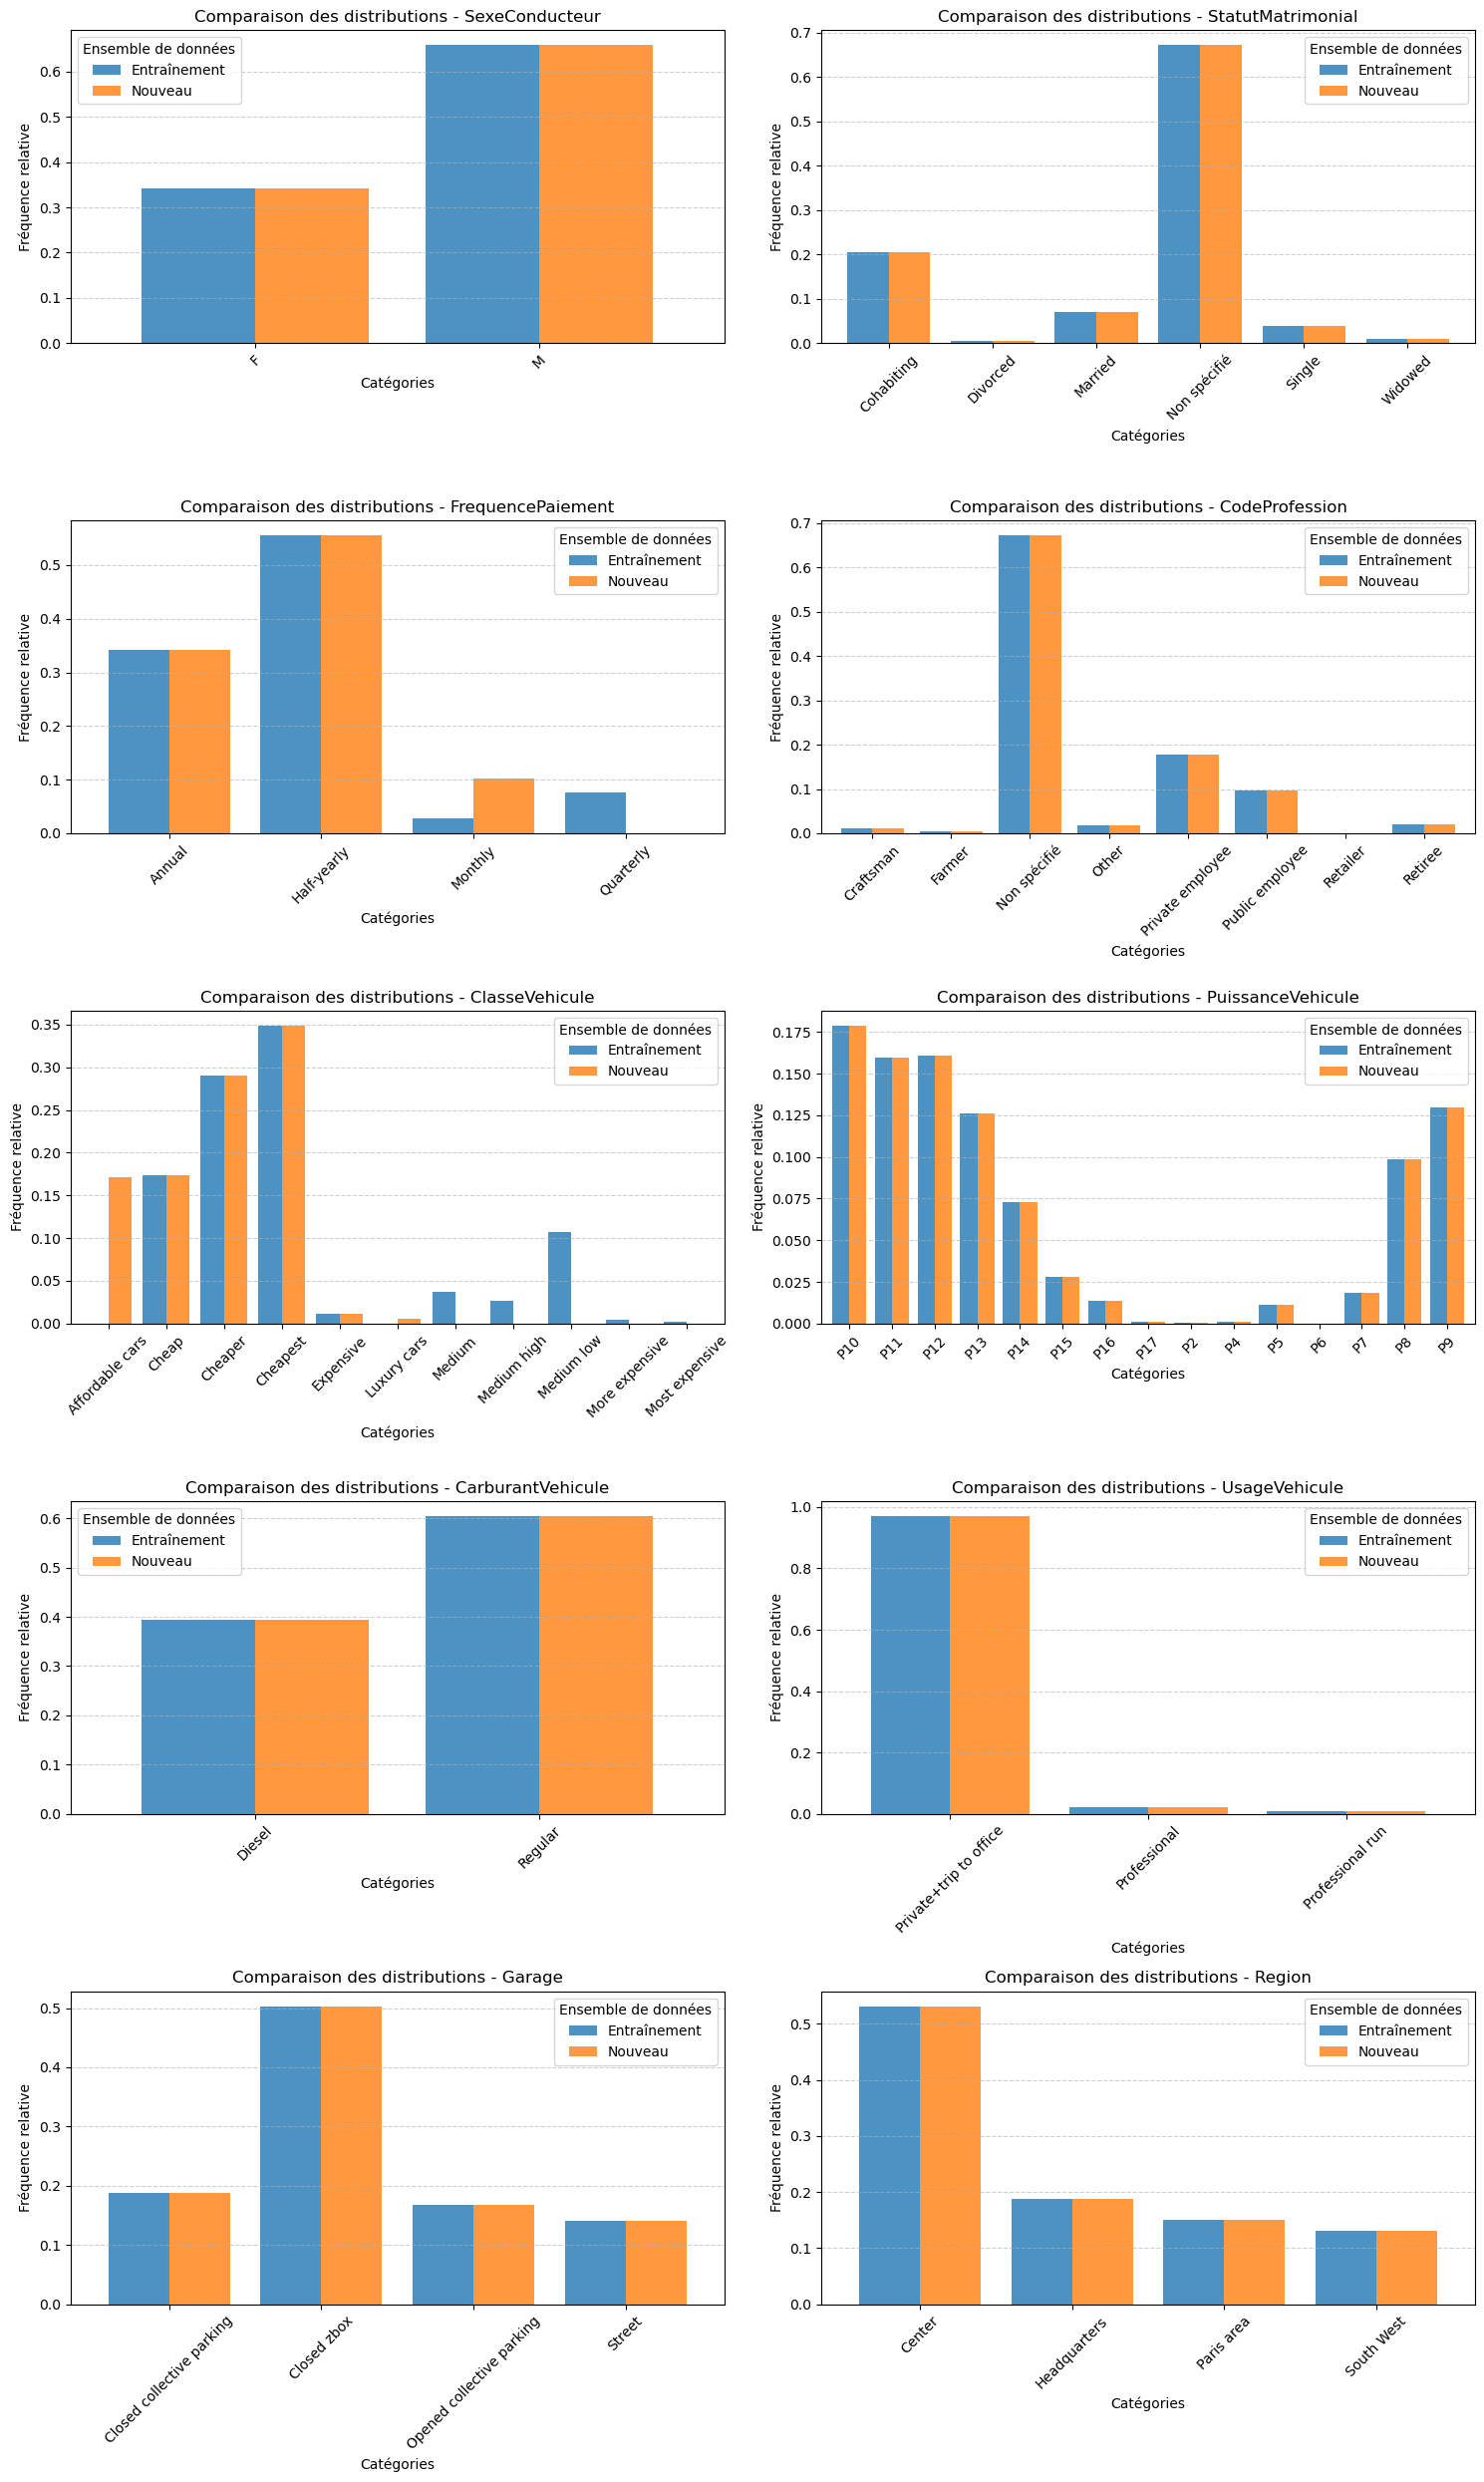

In [108]:
tracer_distributions_categoriques(pre_train, pre_data, Categorical_columns)

Les distributions sont globalement stables. **ClasseVehicle** montre une légère dérive qui pourrait avoir un impact modéré sur les performances.


In [ ]:
for col in Categorical_columns:
          analyze_data_drift(data_train,data_drift,col)


Chi-Square Test pour 'SexeConducteur': Chi2 = 22476.551890806568, p-value = 0.0
Chi-Square Test pour 'StatutMatrimonial': Chi2 = 29488.0, p-value = 0.0
Chi-Square Test pour 'FrequencePaiement': Chi2 = 44962.0, p-value = 0.0
Chi-Square Test pour 'CodeProfession': Chi2 = 44232.0, p-value = 0.0
Chi-Square Test pour 'ClasseVehicule': Chi2 = 112405.00000000003, p-value = 0.0
Chi-Square Test pour 'PuissanceVehicule': Chi2 = 314734.0, p-value = 0.0
Chi-Square Test pour 'CarburantVehicule': Chi2 = 22476.81582092162, p-value = 0.0
Chi-Square Test pour 'UsageVehicule': Chi2 = 44962.0, p-value = 0.0
Chi-Square Test pour 'Garage': Chi2 = 67443.0, p-value = 0.0
Chi-Square Test pour 'Region': Chi2 = 67443.0, p-value = 0.0


# Analyse des Tests Chi-Carré pour les Variables Catégoriques

Les tests Chi-Carré évaluent les différences entre les distributions des variables catégoriques dans les données d'entraînement et les nouvelles données (drift).

---

## Résultats Clés

- **p-value : 0.0** pour toutes les variables.  
  - Les distributions diffèrent significativement, confirmant une **dérive importante** dans les dimensions catégoriques.

---

## Implications

### Changements Observés
- **Évolution démographique** :  
  - Variations dans `SexeConducteur` et `Region`.
- **Usage des véhicules** :  
  - Modifications pour `UsageVehicule` et `ClasseVehicule`.
- **Préférences techniques** :  
  - Changements dans `CarburantVehicule` et `PuissanceVehicule`.

---

## Gestion de la Dérive

### 1. Réentraînement
- **Collecte de données récentes**.  
- **Réentraînement du modèle** avec ces nouvelles données.

### 2. Surveillance Continue
- Automatiser les tests Chi-Carré pour détecter les dérives futures.

---

## Conclusion

Les tests Chi-Carré confirment des **dérives significatives** dans les variables catégoriques. Ces évolutions doivent être adressées par un réentraînement et une surveillance proactive pour maintenir la performance du modèle.


In [47]:
for col in Categorical_columns:
          jsd = calculate_jsd_categorical(data_train, data_drift, col)
          print(f"Jensen-Shannon Divergence for `{col}`: {jsd}")


Jensen-Shannon Divergence for `SexeConducteur`: 0.0
Jensen-Shannon Divergence for `StatutMatrimonial`: 0.0
Jensen-Shannon Divergence for `FrequencePaiement`: 0.1954669855490373
Jensen-Shannon Divergence for `CodeProfession`: 0.0
Jensen-Shannon Divergence for `ClasseVehicule`: 0.35070094478562464
Jensen-Shannon Divergence for `PuissanceVehicule`: 0.0
Jensen-Shannon Divergence for `CarburantVehicule`: 0.0
Jensen-Shannon Divergence for `UsageVehicule`: 0.0
Jensen-Shannon Divergence for `Garage`: 0.0
Jensen-Shannon Divergence for `Region`: 0.0


Priorité à **ClasseVehicule** pour investiguer l'impact de sa dérive.
**FrequencePaiement** nécessite une analyse approfondie pour confirmer son influence.
Les autres variables n'exigent pas d'action immédiate, leur stabilité réduit les risques de dérive conceptuelle.

# Concept drift

### Analyse de la Dérive Conceptuelle : Changements dans l'Importance des Variables

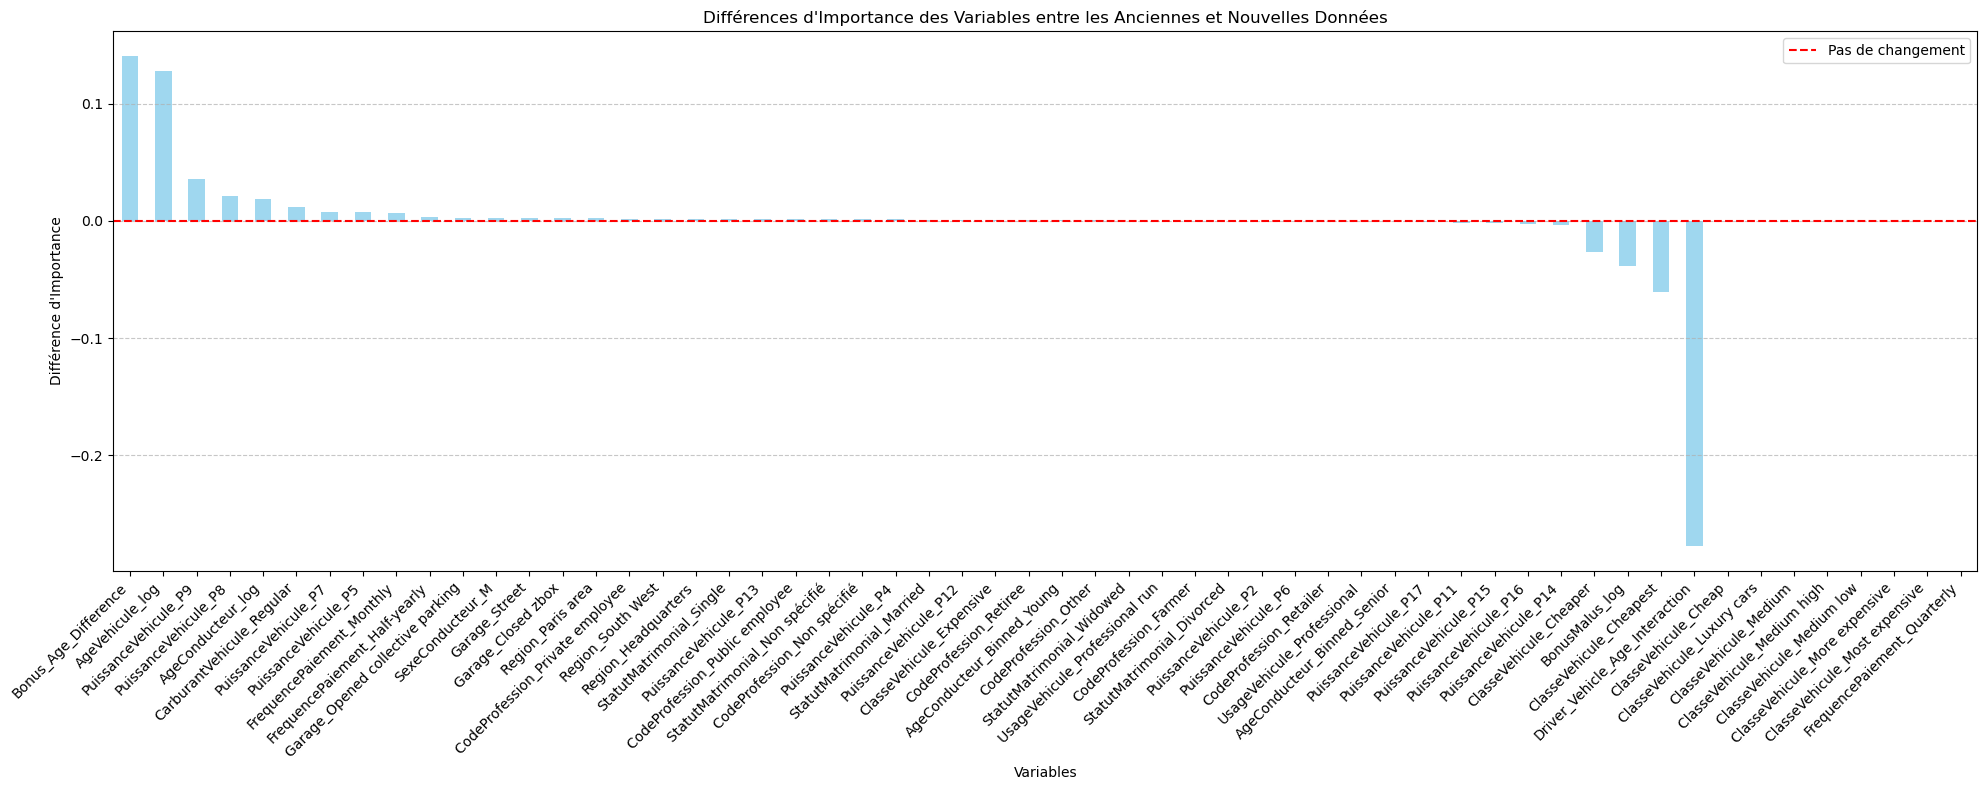

In [ ]:
# Étape 1 : Entraîner un Random Forest sur les données anciennes
rf_model_old = RandomForestRegressor(random_state=42)
rf_model_old.fit(X_train, y_train)

# Étape 2 : Importance des variables sur les données anciennes
feature_importances_old = pd.Series(rf_model_old.feature_importances_, index=X_train.columns)

# Étape 3 : Entraîner un Random Forest sur les nouvelles données
rf_model_new = RandomForestRegressor(random_state=42)
rf_model_new.fit(X, y)

# Étape 4 : Importance des variables sur les nouvelles données
feature_importances_new = pd.Series(rf_model_new.feature_importances_, index=X.columns)

# Étape 5 : Comparer l'importance des variables
importance_diff = feature_importances_new - feature_importances_old

# Étape 6 : Visualisation des différences
plt.figure(figsize=(20, 8))
importance_diff.sort_values(ascending=False).plot(kind='bar', color='skyblue', alpha=0.8)
plt.axhline(y=0, color='red', linestyle='--', label="Pas de changement")
plt.title("Différences d'Importance des Variables entre les Anciennes et Nouvelles Données")
plt.ylabel("Différence d'Importance")
plt.xlabel("Variables")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## Description du Graphique

Le graphique met en évidence les **différences absolues des coefficients** entre les modèles basés sur les anciennes et nouvelles données, classées par impact décroissant.

---

## Observations Clés

### Variables Impactées
- **`AgeVehicule_log`** :  
  - Plus grande différence (> 1.2), indiquant un changement majeur dans son rôle.  

- **`Driver_Vehicle_Age_Interaction`** :  
  - Modification significative des interactions entre âge du conducteur et véhicule.  

- **Classes de véhicules coûteux** :  
  - Changements notables dans la segmentation des véhicules.  

- **`AgeConducteur`** :  
  - Variation modérée reflétant une évolution des profils de conducteurs.

### Variables Stables
- **`StatutMatrimonial_Single`**, **`Garage - Parking`** :  
  - Peu de changements, faible impact.

---

## Impact et Actions

- Les variables clés comme **`AgeVehicule_log`** montrent une **dérive conceptuelle**, réduisant la pertinence des prédictions.  
- **Réentraînement** nécessaire avec des données récentes pour adapter le modèle.

---

## Conclusion

Les variations importantes dans certaines variables clés confirment une **dérive conceptuelle**. Mettre à jour le modèle est crucial pour maintenir des performances fiables.


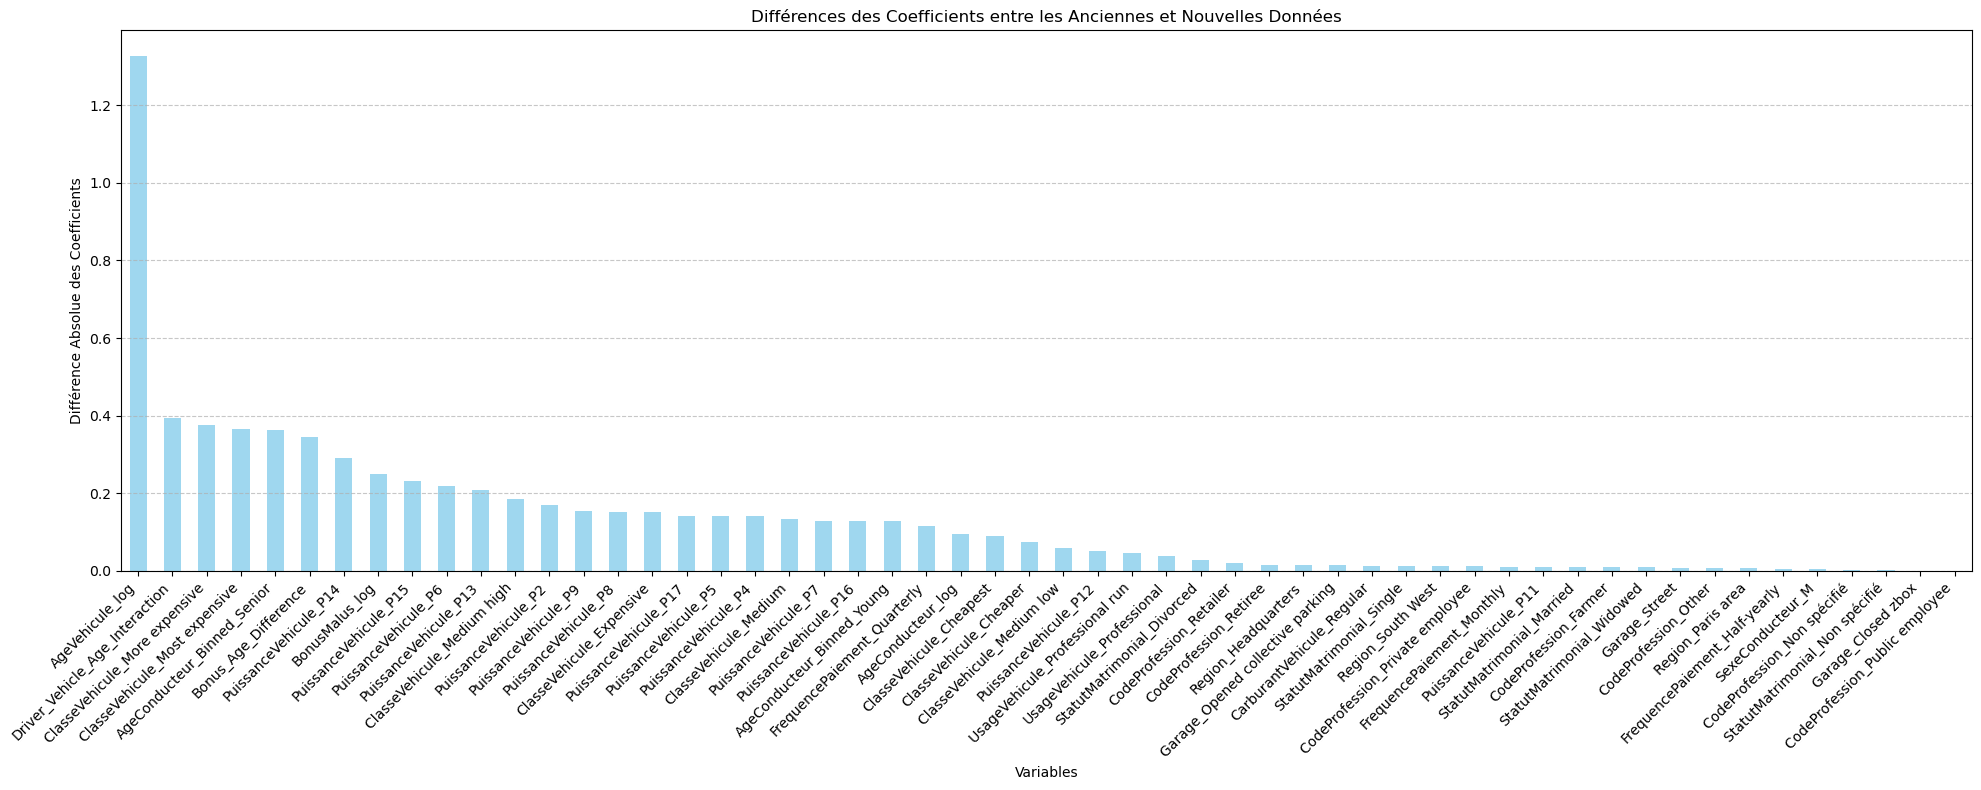

In [ ]:
reg_old = LinearRegression()
reg_old.fit(X_train, y_train)
reg_new = LinearRegression()
reg_new.fit(X, y)

coeff_diff = pd.DataFrame({
    "Feature": X_train.columns,
    "Old Coeff": reg_old.coef_,
    "New Coeff": reg_new.coef_,
    "Difference": np.abs(reg_old.coef_ - reg_new.coef_)
})

plt.figure(figsize=(20, 8))
coeff_diff.set_index("Feature")["Difference"].sort_values(ascending=False).plot(kind="bar", color="skyblue", alpha=0.8)
plt.title("Différences des Coefficients entre les Anciennes et Nouvelles Données")
plt.ylabel("Différence Absolue des Coefficients")
plt.xlabel("Variables")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



## Description du Graphique

Le graphique montre les **différences absolues des coefficients** entre les modèles entraînés sur les anciennes et les nouvelles données. Les variables sont classées par impact décroissant, mettant en évidence les changements significatifs.

---

## Observations Clés

### Variables avec les Plus Grandes Différences
- **`AgeVehicule_log`** :  
  - Plus forte différence (> 1.2), indiquant un changement majeur dans son influence sur la cible.  
  - Facteur clé de la dérive conceptuelle.  

- **`Driver_Vehicle_Age_Interaction`** :  
  - Modifications significatives dans l’interaction entre l’âge du conducteur et celui du véhicule.  

- **Classes de véhicules coûteux (`ClasseVehicule_More expensive`, `Most expensive`)** :  
  - Changements notables dans la segmentation des véhicules.  

- **`AgeConducteur`** :  
  - Variation modérée, indiquant des évolutions des profils de conducteurs.

### Variables avec des Changements Modérés
- Variables liées à la puissance des véhicules (ex. **`PuissanceVehicule_p4`**, **`p15`**) :  
  - Changements dans la distribution ou l’importance de ces variables.

### Variables Stables
- Exemples : **`StatutMatrimonial_Single`**, **`Garage - Parking`** :  
  - Peu de changement, impact négligeable sur la dérive.

---

## Impact sur les Performances

- Variables critiques, comme **`AgeVehicule_log`** et **`Driver_Vehicle_Age_Interaction`**, ont subi des modifications importantes, causant une **dérive conceptuelle**.  
- Les relations modifiées dans les segments de véhicules et les interactions influencent directement les prédictions.

---

## Conclusion

- Les **changements significatifs** dans les coefficients de certaines variables clés signalent une **dérive conceptuelle**.  
- Un **réentraînement** du modèle est indispensable pour rétablir ses performances.



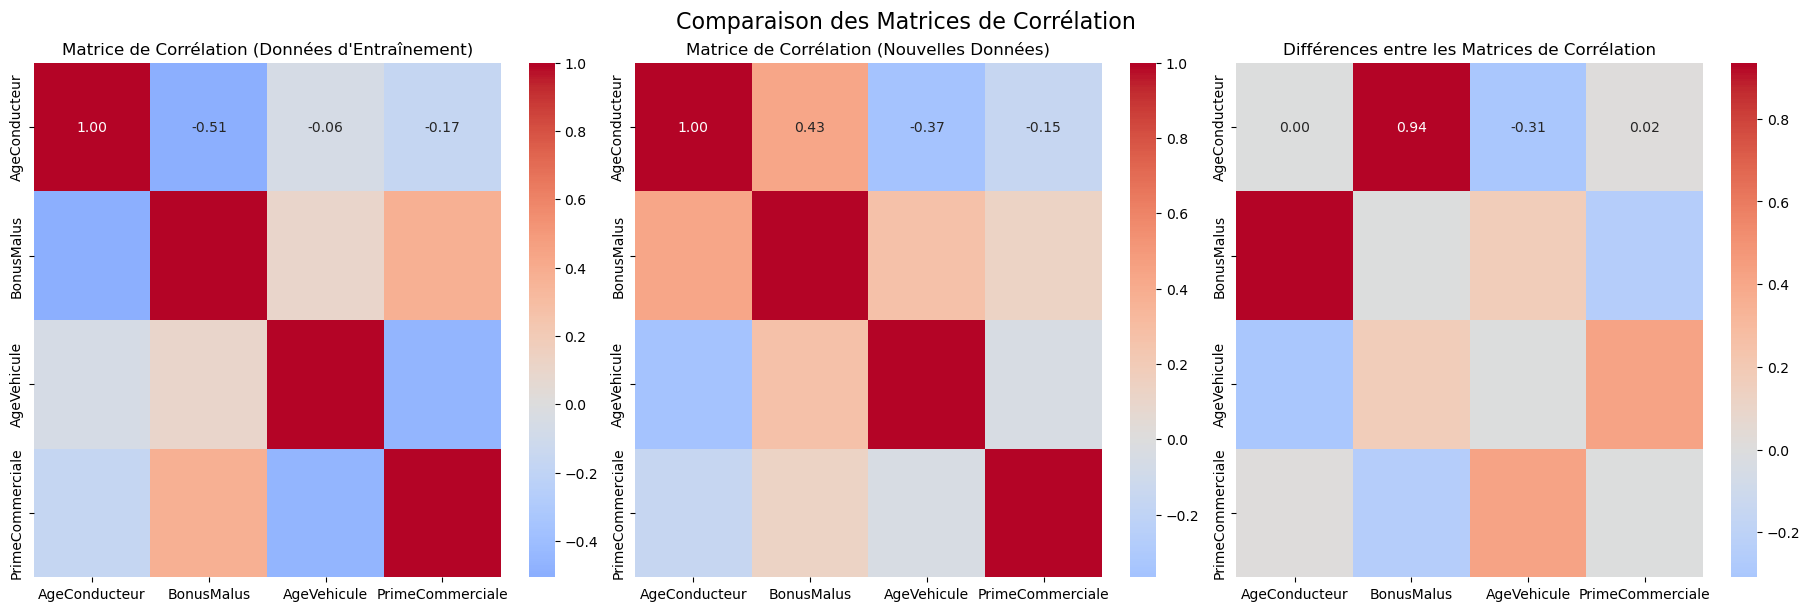

MSE entre les deux matrices de corrélation : 0.1546
Erreur Quadratique Moyenne entre les matrices : 0.15458898853708009


In [158]:
mse_correlation = comparer_matrices_correlation(data_train, data_drift, Numerical_colomuns)
print(f"Erreur Quadratique Moyenne entre les matrices : {mse_correlation}")

## Résumé des Visualisations

Les heatmaps révèlent :  
1. **Corrélation des données d'entraînement** : Relations initiales.  
2. **Corrélation des nouvelles données** : Changements détectés.  
3. **Différences** : Impact des variations.  

---

## Observations Clés

### Données d'Entraînement
- **Relation forte (-0.51)** entre `AgeConducteur` et `BonusMalus`.  
- Corrélation faible entre `AgeVehicule` et `PrimeCommerciale` (-0.06).

### Nouvelles Données
- **Inversion (+0.43)** entre `AgeConducteur` et `BonusMalus`.  
- Faible impact sur `AgeVehicule` et `PrimeCommerciale` (-0.15).

### Différences
- Augmentation de **+0.94** dans `AgeConducteur` et `BonusMalus`.  
- Réduction de **-0.31** entre `AgeConducteur` et `AgeVehicule`.

---

## Impact sur le Modèle

- Changements critiques dans `AgeConducteur` et `BonusMalus` → **dérive conceptuelle**.  
- Relations stables (ex. `PrimeCommerciale`) peu contributives à la dérive.

---

## Recommandations

1. **Réentraînement du Modèle** :  
   Intégrer les nouvelles relations dans le dataset pour aligner le modèle.  
   
2. **Surveillance Continue** :  
   Automatiser la détection de dérives sur les relations clés.

---


- Les relations clés, notamment entre `AgeConducteur` et `BonusMalus`, ont évolué significativement.  
- Un réentraînement et une surveillance proactive sont essentiels pour rétablir les performances et éviter les biais dans les prédictions.


# Conclusion Générale


Les analyses mettent en évidence des **dérives significatives** entre les données d'entraînement et les nouvelles données (drift), affectant la performance du modèle.

---

### Résumé des Problèmes Clés
1. **Dérive Conceptuelle et Distributionnelle :**
   - **`BonusMalus`** et **`PrimeCommerciale`** montrent des divergences importantes (Jensen-Shannon et KS Tests).  
   - Les relations clés entre variables ont changé, notamment entre `AgeConducteur` et `BonusMalus` (inversion de la corrélation).  

2. **Impact sur les Résidus :**
   - Les résidus drift présentent des biais systémiques, une variance accrue et un comportement non normal.  
   - Les prédictions sur le drift sont moins fiables, avec une perte de généralisation.

3. **Différences dans les Coefficients :**
   - Des changements majeurs dans des variables critiques comme `AgeVehicule_log` et `Driver_Vehicle_Age_Interaction` affectent l'interprétation du modèle.

4. **Tests Statistiques :**
   - Les p-values (Chi-Carré, KS) confirment des dérives statistiquement significatives dans les distributions catégoriques et continues.

---

### Conséquences
- Les dérives identifiées entraînent une **dégradation des performances** :  
  - Augmentation des erreurs de prédiction.  
  - Réduction de la robustesse face aux nouvelles observations.  

- Les données d'entraînement sont **obsolètes** et ne reflètent plus les dynamiques actuelles.

---

### Recommandations
1. **Réentraîner le Modèle :**
   - Intégrer des données récentes pour refléter les nouvelles distributions et relations.
   - Inclure les variables critiques comme `BonusMalus` et `AgeVehicule`.

2. **Surveillance Continue :**
   - Automatiser les tests (KS, Chi-Carré, divergence JS) pour détecter et corriger les dérives futures.

3. **Analyse Complémentaire :**
   - Identifier les causes des dérives :
     - Changements démographiques (`AgeConducteur`, `Region`).
     - Évolutions économiques et comportementales (`PrimeCommerciale`, `UsageVehicule`).

---






